In [1]:
import pandas as pd
import numpy as np
import sklearn.neighbors
import sys
import os
sys.path.append(os.path.join("..","Src"))
from img_lib import RasterGrid
from evaluation_utils import MAPE, r2_pearson, r2
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import DistanceMetric
from math import cos, sin, pi
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Get Senegal data and pre-process GPS coordinates

In [2]:
dataset = "../Data/datasets/WFP_ENSAN_Senegal_2013_cluster.csv"

In [3]:
indicator="FCS_mean"

In [4]:
GRID = RasterGrid("../Data/Satellite/F182013.v4c_web.stable_lights.avg_vis.tif")
data = pd.read_csv(dataset)
list_i, list_j = GRID.get_gridcoordinates(data)
hh_data = pd.read_csv(dataset)
hh_data["i"] = list_i
hh_data["j"] = list_j
cluster_N='countbyEA'

In [5]:
wm = lambda x: np.average(x.iloc[:,2], weights=x.loc[x.index, cluster_N],axis=0)

In [6]:
def wavg(g, df, weight_series):
    w = df.ix[g.index][weight_series]
    return (g * w).sum() / w.sum()

In [7]:
import functools
fnc = functools.partial(wavg, df=hh_data, weight_series='countbyEA')

In [8]:
hh_data_grouped=hh_data.groupby(["i", "j"]).agg({'FCS_mean': fnc,'gpsLatitude': fnc,'gpsLongitude': fnc}).reset_index()

/Users/pasquierjb/anaconda3/envs/hrm/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [9]:
CNN_data=pd.read_csv("../Data/Features/features_all_id_81_evaluation.csv")

In [10]:
data = hh_data_grouped.merge(CNN_data, on=["i", "j",indicator])

In [11]:
data = data.loc[data[indicator] > 0]
data = data.sample(frac=1, random_state=1783).reset_index(drop=True)  #shuffle data

In [12]:
data["x"]= data["gpsLatitude"].astype(float).apply(cos) * data["gpsLongitude"].astype(float).apply(cos)
data["y"]= data["gpsLatitude"].astype(float).apply(cos) * data["gpsLongitude"].astype(float).apply(sin)
data["z"]= data["gpsLatitude"].astype(float).apply(sin)

data["gpsLatitude_rad"]= data["gpsLatitude"]* pi / 180
data["gpsLongitude_rad"]= data["gpsLongitude"]* pi / 180

In [13]:
X_CNN = data[list(set(data.columns) - set(hh_data.columns) - set(['index', 'index_x', 'index_y']))]

In [14]:
X_CNN.shape

(996, 1541)

In [15]:
y=data[indicator].values

X=data[["gpsLatitude","gpsLongitude"]]
X2=data[["x","y","z"]]
X3=data[["gpsLatitude_rad","gpsLongitude_rad"]]

In [16]:
#PCA to reduce the number of NN features 
pca = PCA(n_components=15)
X_CNN_PCA = pd.DataFrame(pca.fit_transform(X_CNN))

In [17]:
X_CNN_PCA.shape

(996, 15)

In [18]:
outer_cv = KFold(5, shuffle=True, random_state=75788)
inner_cv = KFold(5, shuffle=True, random_state=1673)
model_grid_parameters= {"alpha":[0.001,0.01,0.1,1,10,100,1000]}

## 2. Linear Regression with CNN features only

In [19]:
clf = GridSearchCV(estimator=Ridge(), param_grid=model_grid_parameters, cv=inner_cv, scoring=r2_pearson)

score = cross_val_score(clf, X_CNN, y, scoring=r2_pearson, cv=outer_cv)
score_r2 = cross_val_score(clf, X_CNN, y, scoring=r2, cv=outer_cv)
score_MAPE = cross_val_score(clf, X_CNN,y, scoring=MAPE, cv=outer_cv)
predict = cross_val_predict(clf, X_CNN, y, cv=outer_cv)

print(score.mean(), score_r2.mean(), score_MAPE.mean())

0.3534370904093958 0.33119679359452875 -0.19762787998674622


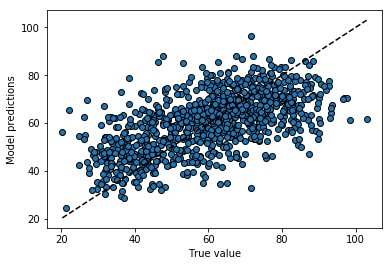

In [20]:
fig, ax = plt.subplots()
ax.scatter(y, predict, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('True value')
ax.set_ylabel('Model predictions')
plt.show()

## 3. k-NN Regression (Pure interpolation)

In [21]:
clf=sklearn.neighbors.KNeighborsRegressor(15,weights='distance',metric='haversine')
outer_cv = KFold(5, shuffle=True, random_state=75788)

score = cross_val_score(clf, X3, y, scoring=r2_pearson, cv=outer_cv)
score_r2 = cross_val_score(clf, X3, y, scoring=r2, cv=outer_cv)
score_MAPE = cross_val_score(clf, X3, y, scoring=MAPE, cv=outer_cv)

predict = cross_val_predict(clf, X, y, cv=outer_cv)

print(score.mean(), score_r2.mean(), score_MAPE.mean())

0.5619884826894043 0.5572006208251634 -0.15792698869956706


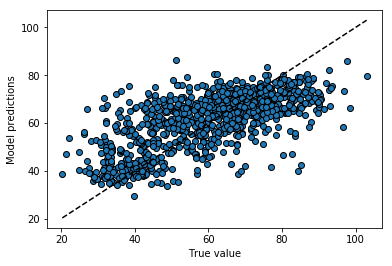

In [22]:
fig, ax = plt.subplots()
ax.scatter(y, predict, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('True value')
ax.set_ylabel('Model predictions')
plt.show()

## 4. Linear Regression with spatial raw predictors (x, y, z) 

In [23]:
X_CNN_PCA_XYZ=pd.concat([data[["x","y","z"]],X_CNN_PCA],axis=1)

In [24]:
clf=Ridge(0.1) #18 features for 1000 data points so low alpha

score = cross_val_score(clf, X_CNN_PCA_XYZ, y, scoring=r2_pearson, cv=outer_cv)
score_r2 = cross_val_score(clf, X_CNN_PCA_XYZ, y, scoring=r2, cv=outer_cv)
score_MAPE = cross_val_score(clf, X_CNN_PCA_XYZ, y, scoring=MAPE, cv=outer_cv)

predict = cross_val_predict(clf, X, y, cv=outer_cv)

print(score.mean(), score_r2.mean(), score_MAPE.mean())

0.40978789048505054 0.40573261294540564 -0.18926385888123465


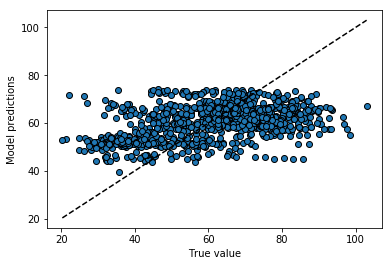

In [25]:
fig, ax = plt.subplots()
ax.scatter(y, predict, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('True value')
ax.set_ylabel('Model predictions')
plt.show()

## 4. Linear Regression with feature engineered spatial predictors

#### 4.1 Spatial Clustering of the EAs

In [26]:
clustering=sklearn.cluster.KMeans(n_clusters=15)
clustering.fit(X2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [27]:
X_zone=clustering.predict(X2)
X_zone_dummies=pd.get_dummies(X_zone) #Create dummy variables for regression 

In [28]:
X_CNN_Zone=pd.concat([X_CNN_PCA,X_zone_dummies],axis=1)

In [29]:
clf=Ridge(0.1)

score = cross_val_score(clf, X_CNN_Zone, y, scoring=r2_pearson, cv=outer_cv)
score_r2 = cross_val_score(clf, X_CNN_Zone, y, scoring=r2, cv=outer_cv)
score_MAPE = cross_val_score(clf, X_CNN_Zone, y, scoring=MAPE, cv=outer_cv)

predict = cross_val_predict(clf, X_CNN_Zone, y, cv=outer_cv)
print(score.mean(), score_r2.mean(), score_MAPE.mean())

0.45335333279768014 0.44817983119475446 -0.17853195195081556


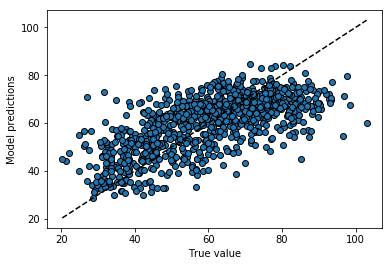

In [30]:
fig, ax = plt.subplots()
ax.scatter(y, predict, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('True value')
ax.set_ylabel('Model predictions')
plt.show()

#### 4.2 Full distance matrix

In [31]:
dist = DistanceMetric.get_metric('haversine')

In [32]:
pca2 = PCA(n_components=20)
X_dist=pd.DataFrame(dist.pairwise(X3))
X_dist_PCA = pd.DataFrame(pca2.fit_transform(X_dist))
X_CNN_Zone_dist=pd.concat([X_CNN_PCA,X_dist_PCA],axis=1)
X_CNN_Zone_dist=sklearn.preprocessing.normalize(X_CNN_Zone_dist)

In [33]:
clf=Ridge(0.01)
outer_cv = KFold(5, shuffle=True, random_state=75788)

score = cross_val_score(clf, X_CNN_Zone_dist, y, scoring=r2_pearson, cv=outer_cv)
score_r2 = cross_val_score(clf, X_CNN_Zone_dist, y, scoring=r2, cv=outer_cv)
score_MAPE = cross_val_score(clf, X_CNN_Zone_dist, y, scoring=MAPE, cv=outer_cv)
predict = cross_val_predict(clf, X_CNN_Zone_dist, y, cv=outer_cv)

predict = cross_val_predict(clf, X_CNN_Zone_dist, y, cv=outer_cv)
print(score.mean(), score_r2.mean(), score_MAPE.mean())

0.3579200120936263 0.35365399655965823 -0.19868238186442022


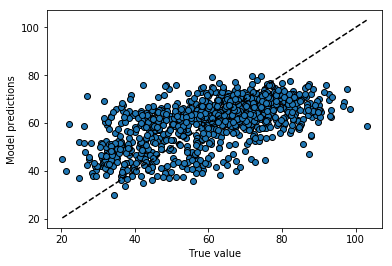

In [34]:
fig, ax = plt.subplots()
ax.scatter(y, predict, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('True value')
ax.set_ylabel('Model predictions')
plt.show()

In [35]:
svr_model = SVR()
rf_model = RandomForestRegressor()
lr_model = LinearRegression(normalize=True, copy_X=True)
models= [svr_model,rf_model,lr_model]

for m in models:
    score = cross_val_score(m, X_CNN_Zone_dist, y, scoring=r2_pearson, cv=outer_cv)
    score_r2 = cross_val_score(m, X_CNN_Zone_dist, y, scoring=r2, cv=outer_cv)
    score_MAPE = cross_val_score(m, X_CNN_Zone_dist, y, scoring=MAPE, cv=outer_cv)

    predict = cross_val_predict(m, X_CNN_Zone_dist, y, cv=outer_cv)
    print(score.mean(), score_r2.mean(), score_MAPE.mean())

0.28254496425257425 0.1295583550891815 -0.24975179237416995
0.5176218824133715 0.5013304976366959 -0.1630491964471999
0.4489150239540545 0.4379115985050775 -0.17807960115670746


## 5. Krigging 
> kriging or Gaussian process regression is a method of interpolation for which the interpolated values are modeled by a Gaussian process governed by prior covariances.

> Under suitable assumptions on the priors, kriging gives the best linear unbiased prediction of the intermediate values.

> kriging has definite limitations, of which the most notable is its assumption of "stationarity," which restricts how much the interpolation can vary in nature across a spatial domain


In [36]:
p=X_CNN_PCA.values
x=X.values
target=y

from pykrige.compat import train_test_split
p_train, p_test, x_train, x_test, target_train, target_test \
    = train_test_split(p, x, target, test_size=0.3, random_state=42)

In [37]:
svr_model = SVR(C=0.1)
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(normalize=True, copy_X=True)
rg_model=Ridge(1)

models = [svr_model, rf_model, lr_model,rg_model]

from pykrige.rk import RegressionKriging
from pykrige.compat import train_test_split

for m in models:
    print('=' * 40)
    print('regression model:', m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=15)
    m_rk.fit(p_train, x_train, target_train)
    print('Regression Score: ', m_rk.regression_model.score(p_test, target_test))
    print('RK score: ', m_rk.score(p_test, x_test, target_test))

regression model: SVR
Finished learning regression model
Finished kriging residuals
Regression Score:  -0.00034993081601708553
RK score:  0.4924333501173498
regression model: RandomForestRegressor
Finished learning regression model
Finished kriging residuals
Regression Score:  0.30751635737442873
RK score:  0.39879664888507504
regression model: LinearRegression
Finished learning regression model
Finished kriging residuals
Regression Score:  0.29321125459986674
RK score:  0.47882065036627575
regression model: Ridge
Finished learning regression model
Finished kriging residuals
Regression Score:  0.2932125426501554
RK score:  0.47882316965938865


In [76]:
X=data[["i","j"]]
y=data[indicator].values

inner_cv = KFold(3, shuffle=True, random_state=1673)
outer_cv = KFold(3, shuffle=True, random_state=75788)

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, DotProduct, RBF 
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.kernel_ridge import KernelRidge


model_grid_parameters={"kernel": [RBF(l) for l in lenghth_param]}

#kernel = RBF(length_scale=[2.0,1.0], length_scale_bounds=(1e-05, 100000.0))

model = GaussianProcessRegressor(alpha=0.1,n_restarts_optimizer=0, normalize_y=False)
clf = GridSearchCV(estimator=model, param_grid=model_grid_parameters, cv=inner_cv, scoring='r2')

score = cross_val_score(clf, X, y, scoring=r2_pearson, cv=outer_cv)

print(score)
print(score.mean())

[0.47740557 0.37190491 0.43936518]
0.4295585531346838


In [77]:
prod_cv = clf.fit(X, y)
print('INFO: best parameter: ', prod_cv.best_params_)

/Users/pasquierjb/anaconda3/envs/hrm/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2, 'nit': 3, 'grad': array([0.00415249, 0.00465452]), 'funcalls': 46}
  " state: %s" % convergence_dict)


INFO: best parameter:  {'kernel': RBF(length_scale=[5, 20])}


In [64]:
np.logspace(-2, 2, 10)

array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])

In [72]:
lenghth_param=[]
for i in (1,5,10,20,50):
    for j in (1,5,10,20,50):
        lenghth_param.append([i,j])

In [73]:
lenghth_param

[[1, 1],
 [1, 5],
 [1, 10],
 [1, 20],
 [1, 50],
 [5, 1],
 [5, 5],
 [5, 10],
 [5, 20],
 [5, 50],
 [10, 1],
 [10, 5],
 [10, 10],
 [10, 20],
 [10, 50],
 [20, 1],
 [20, 5],
 [20, 10],
 [20, 20],
 [20, 50],
 [50, 1],
 [50, 5],
 [50, 10],
 [50, 20],
 [50, 50]]